# Forecast evaluation code

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

## Non-linear models

These three models transform the vector of explanatory variables $S_t$ into a vector of nonlinear transformed variables $G(S_t;\varphi)$.

In [7]:
def TR_model(S_t, gamma):
    return (S_t >= gamma).astype(float).reshape(-1, 1)

def LSTR_model(S_t,gamma,tau):
    return ((1+np.exp(-tau * (S_t-gamma)))**-1).reshape(-1, 1)

def ESTR_model(S_t,gamma,tau):
    return (1-np.exp(-tau * (S_t-gamma)**2)).reshape(-1, 1)

This function detects which model type it should use given the String "$\textit{model_type}$"

In [4]:
def nonlin_model(model_type, S_t, gamma, tau):
    
    if (model_type == "TR"):
        return TR_model(S_t,gamma)
        
    elif (model_type == "LSTR"):
        return LSTR_model(S_t,gamma,tau)
        
    elif (model_type == "ESTR"):
        return ESTR_model(S_t,gamma,tau)
        
    # If we pass another model that is not included, we give an error
    else:
        raise Exception("Model type unknown")

## Plot functions of nonlinear models

In [5]:
#set global variables for the plots
partitions = 1000
start = -4
finish = 3

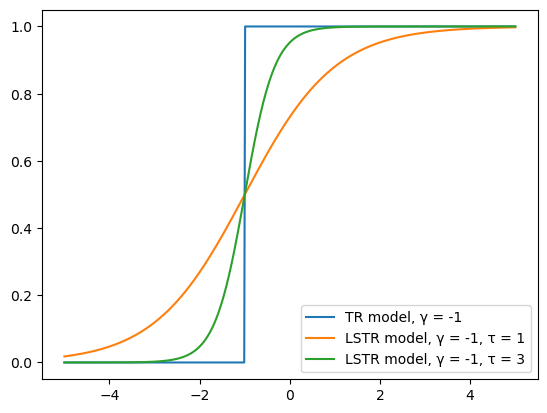

In [9]:
#define parameters
gamma_array = np.array([-1])

#plot all nonlinear functions for each parameter
for gamma in gamma_array:
    sns.lineplot(x=np.linspace(start,finish,partitions),
                 y=TR_model(np.linspace(start,finish,partitions),gamma).T[0],
                 label="TR model, \u03B3 = "+str(gamma))

#define parameters
gamma_array = np.array([-1])
tau_array = np.array([1,3])

#plot all nonlinear functions for each parameter
for gamma in gamma_array:
    for tau in tau_array:
        sns.lineplot(x=np.linspace(start,finish,partitions),
                     y=LSTR_model(np.linspace(start,finish,partitions),gamma,tau).T[0],
                     label="LSTR model, \u03B3 = "+str(gamma)+", \u03C4 = "+str(tau))

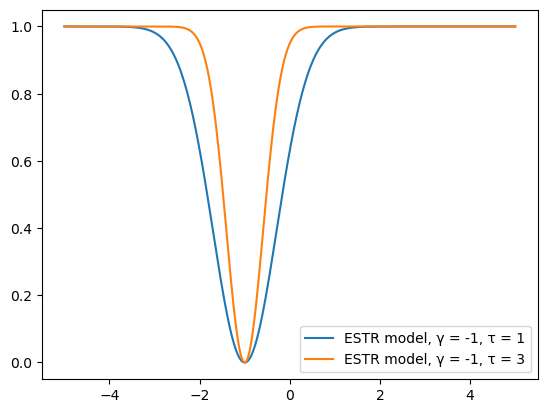

In [8]:
#define parameters
gamma_array = np.array([-1])
tau_array = np.array([1,3])

#plot all nonlinear functions for each parameter
for gamma in gamma_array:
    for tau in tau_array:
        sns.lineplot(x=np.linspace(start,finish,partitions),
                     y=ESTR_model(np.linspace(start,finish,partitions),gamma,tau).T[0],
                     label="ESTR model, \u03B3 = "+str(gamma)+", \u03C4 = "+str(tau))

## Test statistics

In [6]:
def cal_g_theta(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                h_size, # Integer
                model_type # String of model type
                ):
    
    # Determine the size of B
    B_size = round(4*(P_size/100)**(2/9)+1)
    
    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)
    
    # Check which model we should use;
    if (model_type == "TR"):
        
        # Initialize the array for the W_P's
        W_P = np.zeros(grid_elements)
        
        # Create an array of gamma value that are used in the for loop
        gamma_quantile = np.linspace(0.15,0.85,grid_elements)
    
        # Loop over every parameter value to get the W_P's and the updated critical values 
        for i in range(grid_elements):
            W_P[i], W_P_j = cal_test_statistic(S_t, L_t, R_size, P_size, h_size, B_size, v_t, model_type, np.quantile(S_t,gamma_quantile[i]))
            crit_values = np.maximum(crit_values, W_P_j)
    
    else:
        
        # Initialize the array for the W_P's
        W_P = np.zeros(grid_elements**2)
        
        # Create an array of gamma and tau values that are used in the for loop
        gamma_quantile = np.linspace(0.15,0.85,grid_elements)
        tau = np.linspace(0.1,5,grid_elements)
       
        # Loop over every parameter value to get the W_P's and the updated critical values
        for i in range(grid_elements):
            for j in range(grid_elements):
                W_P[i*grid_elements+j], W_P_j = cal_test_statistic(S_t, L_t, R_size, P_size, h_size, B_size, v_t, model_type, np.quantile(S_t,gamma_quantile[i]),tau[j])
                crit_values = np.maximum(crit_values, W_P_j)
    
    # Get the test statistic of all W_P values
    g_theta = max(W_P)
    
    # Sort the Monte Carlo simulations and get critical value
    crit_values.sort()
    final_crit_value = crit_values[round(0.95 * iterations_CV)-1]
    
    # Check if the test statistic 
    if (g_theta > final_crit_value):
        return 1
    else:
        return 0

In [7]:
def cal_test_statistic(S_t, #vector of S_t
                       L_t, #vector of loss function
                       R_size, #integer
                       P_size, #integer
                       h_size, #integer
                       B_size, #integer
                       v_t, #matrix of standard normal distribution
                       model_type, #String of model type
                       gamma, #gamma parameter
                       tau=0  #tau parameter
                       ):
    
    # Initialize the matrix of lambda_sum, V_sum, M_sum
    lambda_sum = np.zeros((2,iterations_CV))
    V_sum = np.zeros((2,2))
    M_sum = np.zeros((2,2))
    
    # Make a vector of ones for X_t
    X_t = np.ones((len(S_t),1))
    
    # Get psi (scalar)
    Q_t = np.column_stack((X_t,np.multiply(X_t,nonlin_model(model_type,S_t,gamma,tau))))
    psi = np.column_stack(estimateBeta(Q_t[R_size:R_size+P_size+h_size],L_t))

    # Loop over t
    for t in range(R_size,R_size+P_size):

        # Select X, S, Y from a certain time range
        X_sel = X_t[t-R_size:t]
        S_sel = S_t[t-R_size:t]
        L_sel = np.column_stack(L_t[t-R_size])        
        
        # Get Q_sel
        Q_sel = np.column_stack((X_sel,np.multiply(X_sel,nonlin_model(model_type,S_sel,gamma,tau))))
        
        # Get residuals
        residual_sel = L_sel - np.column_stack(Q_sel[-1]) @ np.transpose(psi)
        
        # Get score
        score = np.transpose(np.column_stack(Q_sel[-1])) * residual_sel
        
        # Get V and M sum
        V_sum += score * np.transpose(score)
        M_sum += Q_sel[-1] * np.transpose(np.column_stack(Q_sel[-1]))
        
        # Loop over all B
        for b in range(0,B_size):
            lambda_sum += score * v_t[t+b-R_size,:]
    
    # Set Hr to I2
    Hr = np.identity(2)

    # Get V_P and M_P
    V_P = V_sum / P_size
    M_P = M_sum / P_size
    
    # Get Vstar
    V_star = np.linalg.inv(M_P) @ V_P @ np.linalg.inv(M_P)
    
    # Get Wp
    W_P = P_size * (psi @ Hr @ np.linalg.inv(np.transpose(Hr) @ V_star @ Hr) @ np.transpose(Hr) @ np.transpose(psi))

    # Get W_P_j
    lambda_P = (lambda_sum / (P_size*(1+B_size))**0.5).T
    W_P_j = np.sum(np.matmul(lambda_P, np.linalg.inv(M_P) @ Hr @ np.linalg.inv(np.transpose(Hr) @ V_star @ Hr) @ np.transpose(Hr) @ np.linalg.inv(M_P)) * lambda_P,axis=1)

    # Return the test statistic and critical values
    return W_P, W_P_j

In [8]:
# Simple method to estimate the OLS estimates
def estimateBeta(Z_t,Y_t):
    return np.linalg.inv(np.transpose(Z_t) @ Z_t) @ np.transpose(Z_t) @ Y_t

## Model 1

In [9]:
def MonteCarlo_1(iterations,R,P,h,T,model_type = "TR"):
        
    #define variable to keep track of amount of rejects
    MC_array = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration)(iterations,R,P,h,T,model_type) for i in range(iterations))
    
    print(np.mean(MC_array))


def MonteCarlo_iteration(iterations,R,P,h,T,model_type):
    #simulate model, it only returns vectors:
    sim_z1, sim_z2, sim_y_t, sim_S_t = sim_model_1(T)

    delta_L = cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R, P, h, T)
        
    return cal_g_theta(S_t=sim_S_t, Y_t=delta_L, R_size=R, P_size=P, h_size=h, model_type=model_type)


def sim_model_1(T):
    y_t = np.zeros((T,1))
    delta1 = delta2 = v = 1
    z1 = np.random.normal(0,1,(T,1))
    z2 = np.random.normal(0,1,(T,1))
    S_t = np.random.normal(0,1,(T,1))
    
    y_t = v + delta1 + z1 + delta2 + z2 + np.random.normal(0, 1, (T,1))

    #return vector values
    return z1, z2, y_t, S_t


def cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R, P, h, T):
    sim_z1 = np.column_stack([np.ones((T,1)),sim_z1])
    sim_z2 = np.column_stack([np.ones((T,1)),sim_z2])
    
    delta_L = np.zeros((P,1))
    
    for t in range(R, T+1-h):
        z1_sel = sim_z1[t-R:t]
        z2_sel = sim_z2[t-R:t]
        y_sel = sim_y_t[t-R+h:t+h]
        
        beta_1 = estimateBeta(z1_sel,y_sel)
        beta_2 = estimateBeta(z2_sel,y_sel)

        forecast1 = beta_1[0] + z1_sel[-1,1] * beta_1[1]
        forecast2 = beta_2[0] + z2_sel[-1,1] * beta_2[1]

        delta_L[t-R] = (y_sel[-1] - forecast1)**2 - (y_sel[-1] - forecast2)**2
    
    return delta_L

Choose one of the following model types:
1. "TR"
2. "LSTR"
3. "ESTR"

In [10]:
#simulation speed:
MC_iterations = 200
grid_elements = 20
iterations_CV = 200

# You can modify these variables
R_MC = 25
P_MC = 100

# Do not modify these variables
h_MC = 1
T_MC = R_MC + P_MC + h_MC - 1

# MonteCarlo_1(MC_iterations, R_MC, P_MC,h_MC,T_MC,"TR")
MonteCarlo_1(MC_iterations, R_MC, P_MC,h_MC,T_MC,"TR")

NameError: name 'MonteCarlo_1' is not defined